## Context

This notebook is derived from the work shared by Instagram co-founder Kevin Systrom on their [github page](https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb) 

It uses a Bayesian approach to calculate the effective reproduction number. This is based on the work of [Bettencourt & Ribeiro](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185) 

The effective reproduction number $R_t$ is the number of people who get infected per infectious person at time $t$
It's an useful measure to control the epidemic at a local level. 

When $R >> 1$ then the epidemic will infect a large percentage of the population. But if it's brought down such that $R << 1$ then it dies out. 

## Data

Data is taken from covid warriors [covid19india.org](https://api.covid19india.org/csv/)

## Conclusions

**Overall states (incl. Maharashtra & Delhi) are showing a falling trend**

However these numbers should be taken with caution (??) check the graph for Karnataka, where $R_t$ was below 1 , but since has crept above the *benchline* of **1.0** . 



## Assumptions & Constraints
1. We are calculating the $R_t$ value based on *reported* new cases. Any discrepancies in those values will have an impact on the calculated $R_t$ 
2. Number of cases infected (actual infections) in the past 4-7 days may not be reported, hence those numbers are not reflected in the caluations
3. Smoothing approach (rolling) used may be contentious. See discussion [issue](https://github.com/k-sys/covid-19/issues/30)
4. Initial high values of $R$ was because testing intensity had increased, so there were a huge spike in number of infections. ie. *The numbers are high JUST because high number of patients were tested* 
5. Assumptions are based on statistical inference.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import json

In [2]:
# Get csv file & json (latest) dumps
!wget https://api.covid19india.org/csv/latest/raw_data1.csv
!wget https://api.covid19india.org/csv/latest/raw_data2.csv
!wget https://api.covid19india.org/csv/latest/raw_data3.csv
!wget https://api.covid19india.org/csv/latest/statewise_tested_numbers_data.csv
!wget https://api.covid19india.org/csv/latest/tested_numbers_icmr_data.csv
!ls

--2020-05-01 23:13:38--  https://api.covid19india.org/csv/latest/raw_data1.csv
Resolving api.covid19india.org (api.covid19india.org)... 185.199.110.153, 185.199.108.153, 185.199.111.153, ...
Connecting to api.covid19india.org (api.covid19india.org)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2834282 (2.7M) [text/csv]
Saving to: ‘raw_data1.csv’

raw_data1.csv       100%[===================>]   2.70M  13.2MB/s    in 0.2s    

2020-05-01 23:13:39 (13.2 MB/s) - ‘raw_data1.csv’ saved [2834282/2834282]

--2020-05-01 23:13:40--  https://api.covid19india.org/csv/latest/raw_data2.csv
Resolving api.covid19india.org (api.covid19india.org)... 185.199.108.153, 185.199.109.153, 185.199.111.153, ...
Connecting to api.covid19india.org (api.covid19india.org)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1537822 (1.5M) [text/csv]
Saving to: ‘raw_data2.csv’

raw_data2.csv       100%[===================>]   1.47M  --

In [3]:
statewise_tests = pd.read_csv('statewise_tested_numbers_data.csv')
icmr_tests = pd.read_csv('tested_numbers_icmr_data.csv')
raw_data1 = pd.read_csv('raw_data1.csv')
raw_data2 = pd.read_csv('raw_data2.csv')
raw_data3 = pd.read_csv('raw_data3.csv')

In [4]:
print(raw_data1.columns)
print(raw_data2.columns)
print(raw_data3.columns)

Index(['Patient Number', 'State Patient Number', 'Date Announced',
       'Estimated Onset Date', 'Age Bracket', 'Gender', 'Detected City',
       'Detected District', 'Detected State', 'State code', 'Current Status',
       'Notes', 'Contracted from which Patient (Suspected)', 'Nationality',
       'Type of transmission', 'Status Change Date', 'Source_1', 'Source_2',
       'Source_3', 'Backup Notes'],
      dtype='object')
Index(['Patient Number', 'State Patient Number', 'Date Announced',
       'Estimated Onset Date', 'Age Bracket', 'Gender', 'Detected City',
       'Detected District', 'Detected State', 'State code', 'Current Status',
       'Notes', 'Contracted from which Patient (Suspected)', 'Nationality',
       'Type of transmission', 'Status Change Date', 'Source_1', 'Source_2',
       'Source_3', 'Backup Notes'],
      dtype='object')
Index(['Entry_ID', 'State Patient Number', 'Date Announced', 'Age Bracket',
       'Gender', 'Detected City', 'Detected District', 'Detected S

In [5]:
raw_data3 = raw_data3.rename(columns ={'Entry_ID':'Patient Number'}) #Rename column name identifying patient
raw_data3 = raw_data3[raw_data3['Current Status'] == 'Hospitalized']

sum(raw_data3['Date Announced'].isnull()) # Not required since the above step removes these rows 
raw_data3.dropna(subset=['Date Announced'])

raw_data3['Date Announced'] = pd.to_datetime(raw_data3['Date Announced'], format = "%d/%m/%Y")
raw_data3['Num Cases'] = raw_data3['Num Cases'].astype('float64')


In [6]:
raw_data3[raw_data3['Num Cases']<0.0] # Leave this as is ! 

,Patient Number,State Patient Number,Date Announced,Age Bracket,Gender,Detected City,Detected District,Detected State,State code,Num Cases,Current Status,Contracted from which Patient (Suspected),Notes,Source_1,Source_2,Source_3,Nationality,Type of transmission,Status Change Date
803,804,NaN,2020-04-28,NaN,NaN,NaN,Dewas,Madhya Pradesh,MP,-1.0,Hospitalized,NaN,2 patients from yesterday were transferred to ...,https://twitter.com/JansamparkMP/status/125514...,NaN,NaN,NaN,NaN,NaN


In [7]:
raw_data3 = pd.DataFrame(raw_data3.groupby(['Detected State', 'Date Announced']).agg('sum')['Num Cases'])
raw_data3.columns = ['Patient Number']
raw_data3

Patient Number
Detected State Date Announced                
Andhra Pradesh 2020-04-27                80.0
               2020-04-28                82.0
               2020-04-29                73.0
               2020-04-30                71.0
               2020-05-01                60.0
...                                       ...
West Bengal    2020-04-27                38.0
               2020-04-28                48.0
               2020-04-29                28.0
               2020-04-30                33.0
               2020-05-01                37.0

[102 rows x 1 columns]

In [8]:
raw_data3.idxmax()

Patient Number    (Maharashtra, 2020-05-01 00:00:00)
dtype: object

In [9]:
raw_data1 = raw_data1[['Patient Number', 'State Patient Number', 'Date Announced',
       'Age Bracket', 'Gender', 'Detected City',
       'Detected District', 'Detected State', 'Nationality', 'Type of transmission']]

raw_data2 = raw_data2[['Patient Number', 'State Patient Number', 'Date Announced',
       'Age Bracket', 'Gender', 'Detected City',
       'Detected District', 'Detected State', 'Nationality', 'Type of transmission']]

raw_data = pd.concat([raw_data1, raw_data2])
print(raw_data.shape)
raw_data.head()

(27891, 10)


,Patient Number,State Patient Number,Date Announced,Age Bracket,Gender,Detected City,Detected District,Detected State,Nationality,Type of transmission
0,1,KL-TS-P1,30/01/2020,20,F,Thrissur,Thrissur,Kerala,India,Imported
1,2,KL-AL-P1,02/02/2020,NaN,NaN,Alappuzha,Alappuzha,Kerala,India,Imported
2,3,KL-KS-P1,03/02/2020,NaN,NaN,Kasaragod,Kasaragod,Kerala,India,Imported
3,4,DL-P1,02/03/2020,45,M,East Delhi (Mayur Vihar),East Delhi,Delhi,India,Imported
4,5,TS-P1,02/03/2020,24,M,Hyderabad,Hyderabad,Telangana,India,Imported


In [10]:
raw_data.dtypes

Patient Number           int64
State Patient Number    object
Date Announced          object
Age Bracket             object
Gender                  object
Detected City           object
Detected District       object
Detected State          object
Nationality             object
Type of transmission    object
dtype: object

In [11]:
raw_data['Age Bracket'] = raw_data['Age Bracket'].apply(lambda x : 30 if str(x).__contains__('-') else x)# Around 4-5 rows have age ranges 28-35. Replacing it with 30
raw_data['Date Announced'] = pd.to_datetime(raw_data['Date Announced'], format = "%d/%m/%Y")

raw_data['Age Bracket'] = raw_data['Age Bracket'].astype('float64')
raw_data['Gender'] = raw_data['Gender'].astype('category')
raw_data['Detected City'] = raw_data['Detected City'].astype('category')
raw_data['Detected District'] = raw_data['Detected District'].astype('category')
raw_data['Detected State'] = raw_data['Detected State'].astype('category')

raw_data['Nationality'] = raw_data['Nationality'].astype('category')
raw_data['Type of transmission'] = raw_data['Type of transmission'].astype('category')

In [12]:
# Check latest date
np.max(raw_data['Date Announced'])

Timestamp('2020-04-26 00:00:00')

## Some quick visualizations
- new cases per day (across the country
- age distribution
- gender distribution
- case counts grouped by states

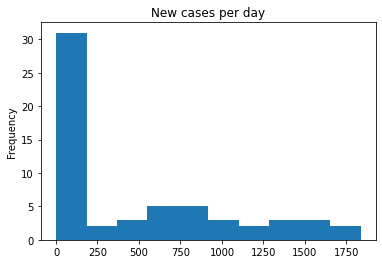

In [13]:
# Quickly visualizing the per/day new cases (across the country)
raw_data.groupby(raw_data['Date Announced']).count()['Patient Number'].plot(kind='hist',title='New cases per day')

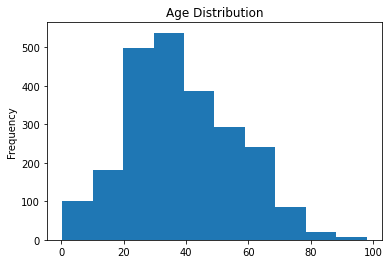

In [14]:
raw_data['Age Bracket'].plot(kind='hist',title='Age Distribution')

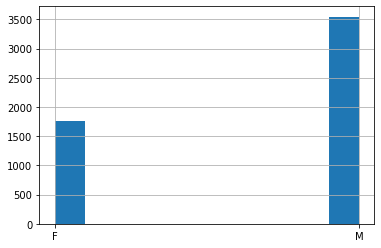

In [15]:
raw_data['Gender'].hist()

In [16]:
raw_data['Detected State'].value_counts()

Maharashtra                    8068
Gujarat                        3301
Delhi                          2918
Rajasthan                      2185
Madhya Pradesh                 2090
Tamil Nadu                     1885
Uttar Pradesh                  1873
Andhra Pradesh                 1097
Telangana                      1001
West Bengal                     611
Jammu and Kashmir               523
Karnataka                       503
Kerala                          469
Punjab                          322
Haryana                         296
Bihar                           277
Odisha                          103
Jharkhand                        82
Uttarakhand                      51
Himachal Pradesh                 40
Chhattisgarh                     37
Chandigarh                       36
Assam                            36
Andaman and Nicobar Islands      33
Ladakh                           20
Meghalaya                        12
Puducherry                        8
Goa                         

In [17]:
states = pd.DataFrame(raw_data.groupby(['Detected State', 'Date Announced']).agg('count')['Patient Number'])
states = pd.concat([states, raw_data3], sort = True)
states

Patient Number
Detected State              Date Announced                
Andaman and Nicobar Islands 2020-01-30                 NaN
                            2020-02-02                 NaN
                            2020-02-03                 NaN
                            2020-03-02                 NaN
                            2020-03-03                 NaN
...                                                    ...
West Bengal                 2020-04-27                38.0
                            2020-04-28                48.0
                            2020-04-29                28.0
                            2020-04-30                33.0
                            2020-05-01                37.0

[1990 rows x 1 columns]

From here we will try to replicate the calculation of $R_t$ for India & it's states

In [18]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

In [19]:
# Column vector of k
k = np.arange(0, 2000)[:, None]
print(k.shape)

# Different values of Lambda
lambdas = [10, 20, 30, 40, 80, 100, 250, 500, 750, 1000, 1250, 1500, 1750]

# Evaluated the Probability Mass Function (remember: poisson is discrete)
y = sps.poisson.pmf(k, lambdas)

# Show the resulting shape
print(y.shape)

(2000, 1)
(2000, 13)


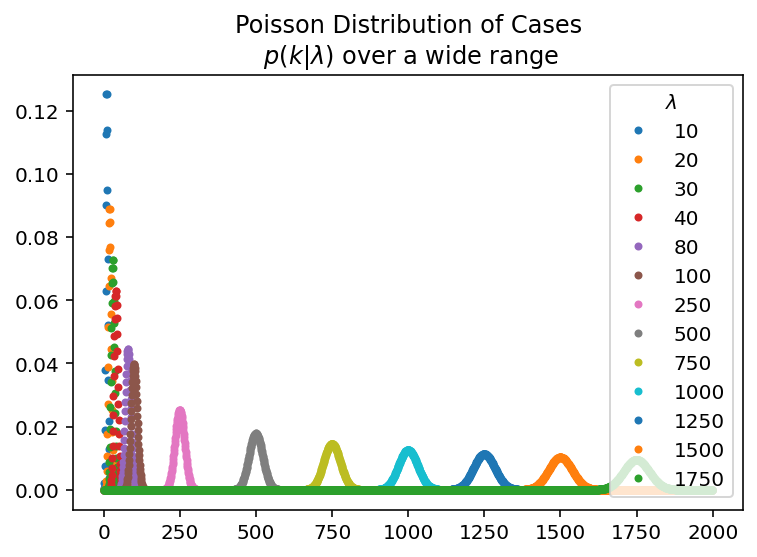

In [20]:
fig, ax = plt.subplots()

ax.set(title='Poisson Distribution of Cases\n $p(k|\lambda)$ over a wide range')

plt.plot(k, y,
         marker='o',
         markersize=3,
         lw=0)

plt.legend(title="$\lambda$", labels=lambdas);


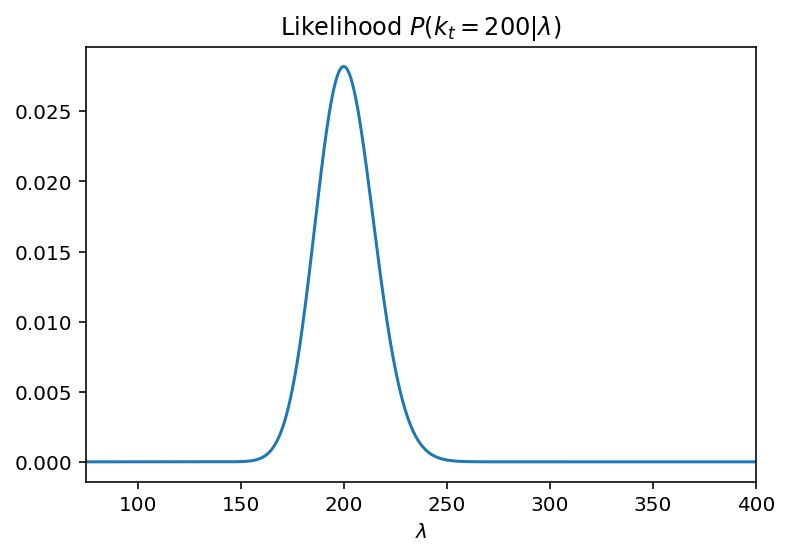

In [21]:
k = 200

lam = np.linspace(75, 400, 800)

likelihood = pd.Series(data=sps.poisson.pmf(k, lam),
                       index=pd.Index(lam, name='$\lambda$'),
                       name='lambda')

likelihood.plot(title=r'Likelihood $P\left(k_t=200|\lambda\right)$');

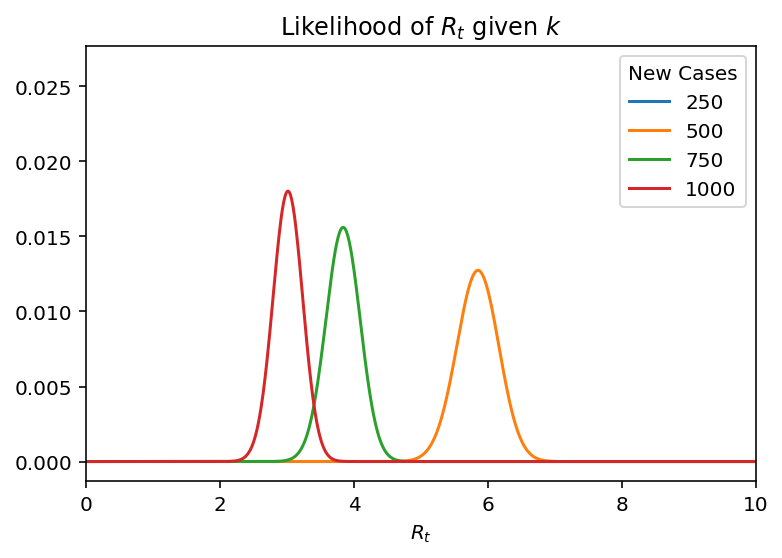

In [22]:
k = np.array([50, 250, 500, 750, 1000])

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7

# Map Rt into lambda so we can substitute it into the equation below
# Note that we have N-1 lambdas because on the first day of an outbreak
# you do not know what to expect.
lam = k[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))

# Evaluate the likelihood on each day and normalize sum of each day to 1.0
likelihood_r_t = sps.poisson.pmf(k[1:], lam)
likelihood_r_t /= np.sum(likelihood_r_t, axis=0)

# Plot it
ax = pd.DataFrame(
    data = likelihood_r_t,
    index = r_t_range
).plot(
    title='Likelihood of $R_t$ given $k$',
    xlim=(0,10)
)

ax.legend(labels=k[1:], title='New Cases')
ax.set_xlabel('$R_t$');


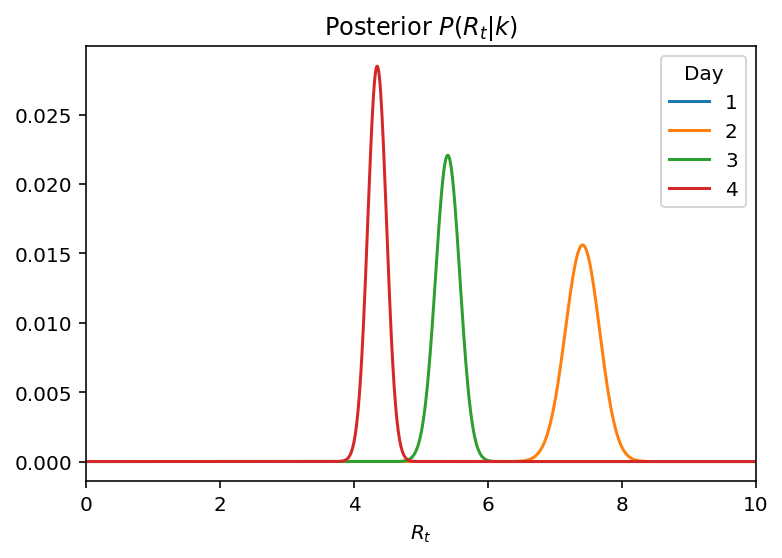

In [23]:
posteriors = likelihood_r_t.cumprod(axis=1)
posteriors = posteriors / np.sum(posteriors, axis=0)

columns = pd.Index(range(1, posteriors.shape[1]+1), name='Day')
posteriors = pd.DataFrame(
    data = posteriors,
    index = r_t_range,
    columns = columns)

ax = posteriors.plot(
    title='Posterior $P(R_t|k)$',
    xlim=(0,10)
)
ax.legend(title='Day')
ax.set_xlabel('$R_t$');

In [24]:
# Calculating most likely posterior values

most_likely_values = posteriors.idxmax(axis=0)
most_likely_values

Day
1    12.00
2     7.41
3     5.40
4     4.35
dtype: float64

Nxt a function is created to calculate the confidence interval of the $R_t$ estimates

In [25]:
def highest_density_interval(pmf, p=.9, column=None):
    
    # debuggin step << Used this to identify that I had incorrectly concatenated the files
#     if column:
#         print(column)
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p, column=col) for col in pmf],
                            index=pmf.columns)
    cumsum = np.cumsum(pmf.values)
    best = None
    for i, value in enumerate(cumsum):
        for j, high_value in enumerate(cumsum[i+1:]):
            if (high_value-value > p) and (not best or j<best[1]-best[0]):
                best = (i, i+j+1)
                break
            
    low = pmf.index[best[0]]
    high = pmf.index[best[1]]
    return pd.Series([low, high], index=[f'Low_{p*100:.0f}', f'High_{p*100:.0f}'])

hdi = highest_density_interval(posteriors)
hdi.tail()


,Low_90,High_90
Day,,
1,11.39,12.00
2,7.01,7.86
3,5.11,5.71
4,4.13,4.60


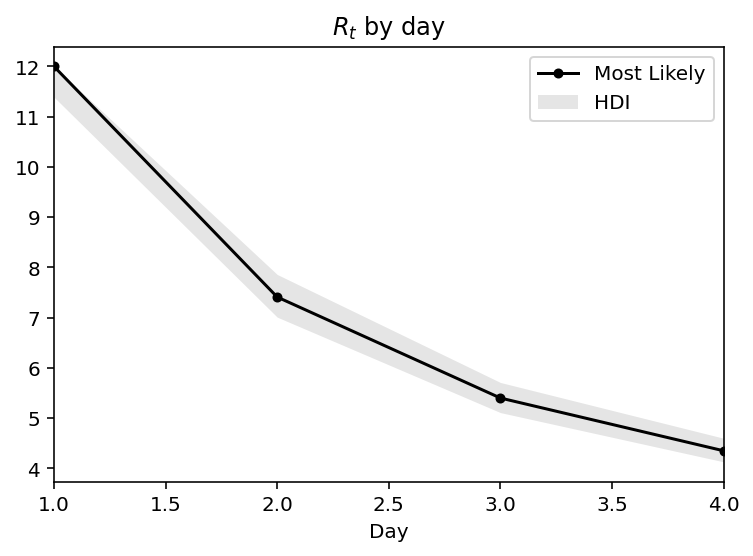

In [26]:
ax = most_likely_values.plot(marker='o',
                             label='Most Likely',
                             title=f'$R_t$ by day',
                             c='k',
                             markersize=4)

ax.fill_between(hdi.index,
                hdi['Low_90'],
                hdi['High_90'],
                color='k',
                alpha=.1,
                lw=0,
                label='HDI')

ax.legend();

Taking a look at the state, we need to start the analysis when there are a consistent number of cases each day. Find the last zero new case day and start on the day after that.

Also, case reporting is very erratic based on testing backlogs, etc. To get the best view of the 'true' data we can, I've applied a gaussian filter to the time series. This is obviously an arbitrary choice, but you'd imagine the real world process is not nearly as stochastic as the actual reporting.

In [27]:
state_name = "Delhi"

def prepare_cases(cases):
    new_cases = cases

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    smoothed.fillna(0, inplace=True)
    
    zeros = smoothed.index[smoothed['Patient Number'].eq(0)]
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed.index.get_loc(last_zero) + 1
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

cases = states.xs(state_name) #.rename(f"{state_name} cases")

original, smoothed = prepare_cases(cases)

In [28]:
import plotly.express as px

from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py

init_notebook_mode(connected=True)
import plotly.graph_objs as go

In [29]:
# Creating trace1
trace1 = go.Scatter(
                    x = original.index,
                    y = original['Patient Number'],
                    mode = "lines",
                    name = "actual",
                    marker = dict(color = 'rgba(16, 25, 160, 0.4)')
                    )
# Creating trace2
trace2 = go.Scatter(
                    x = smoothed.index,
                    y = smoothed['Patient Number'],
                    mode = "lines+markers",
                    name = "smoothed",
                    marker = dict(color = 'rgba(16, 8, 250, 1.0)')
                    )
data = [trace1, trace2]
layout = dict(title = f'{state_name} Number of cases'
             )
fig = dict(data = data, layout = layout)
iplot(fig)


In [30]:
def get_posteriors(sr, sigma=0.15):
    
    sr = sr['Patient Number']
    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

# Note that we're fixing sigma to a value just for the example
posteriors, log_likelihood = get_posteriors(smoothed, sigma=.15)


In [31]:
log_likelihood

-180.21627669261417

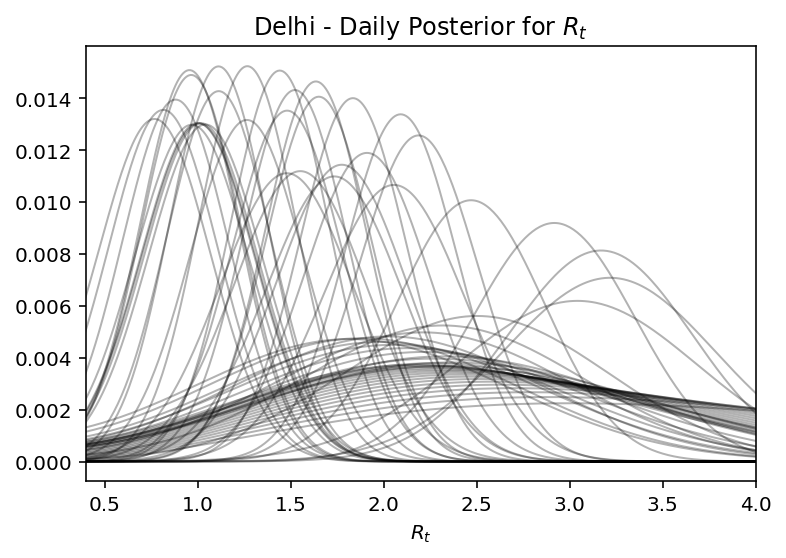

In [32]:
ax = posteriors.plot(title=f'{state_name} - Daily Posterior for $R_t$',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4,4))

ax.set_xlabel('$R_t$');

In [33]:
# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors, p=.9)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

result.tail()

,ML,Low_90,High_90
Date Announced,,,
2020-04-27,1.44,1.03,1.91
2020-04-28,1.27,0.86,1.73
2020-04-29,1.11,0.70,1.57
2020-04-30,0.96,0.54,1.42
2020-05-01,0.96,0.55,1.44


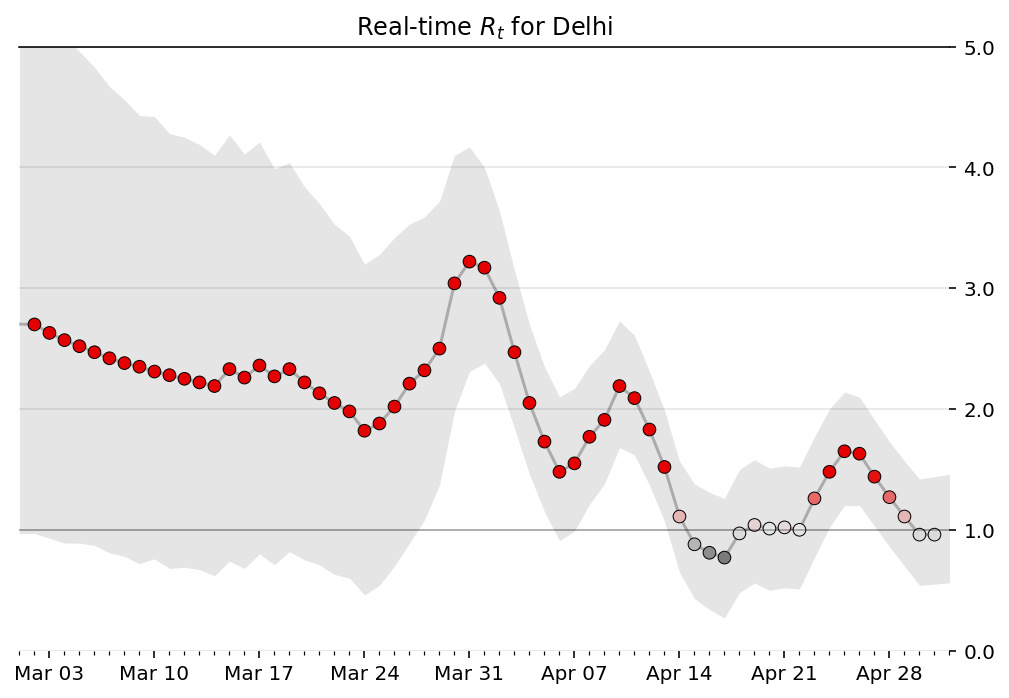

In [34]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('Date Announced')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('Date Announced')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

    
fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_rt(result, ax, state_name)
ax.set_title(f'Real-time $R_t$ for {state_name}')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

In [35]:
sigmas = np.linspace(1/20, 1, 20)

# Determing targets as only the first 15 states
targets = list(raw_data['Detected State'].value_counts().index[:16])
states_to_process = states.loc[targets]

results = {}

In [36]:
%%time

for state_name in targets:
    
    print(state_name)
    cases = states_to_process.xs(state_name)
    new, smoothed = prepare_cases(cases)
    
    result = {}
    
    # Holds all posteriors with every given value of sigma
    result['posteriors'] = []
    
    # Holds the log likelihood across all k for each value of sigma
    result['log_likelihoods'] = []
    
    for sigma in sigmas:
        posteriors, log_likelihood = get_posteriors(smoothed, sigma=sigma)
        result['posteriors'].append(posteriors)
        result['log_likelihoods'].append(log_likelihood)
    
    # Store all results keyed off of state name
    results[state_name] = result
    clear_output(wait=True)

print('Done.')

Done.
CPU times: user 3min 21s, sys: 2min 50s, total: 6min 12s
Wall time: 1min 54s


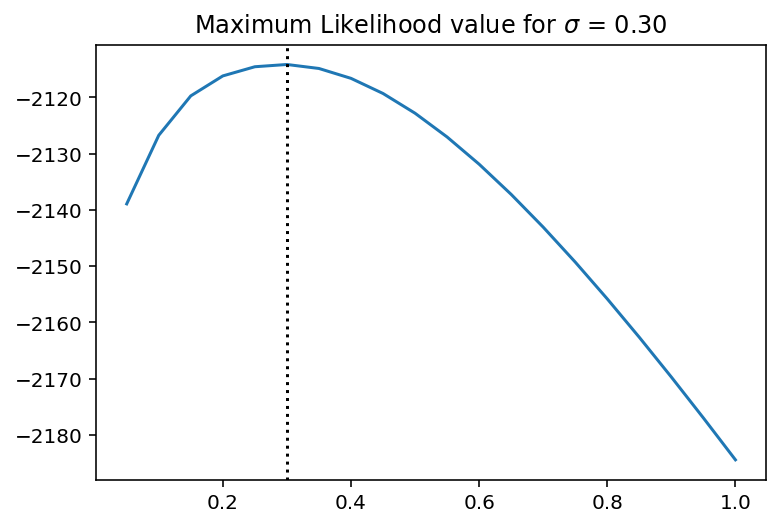

In [37]:
# Each index of this array holds the total of the log likelihoods for
# the corresponding index of the sigmas array.
total_log_likelihoods = np.zeros_like(sigmas)

# Loop through each state's results and add the log likelihoods to the running total.
for state_name, result in results.items():
    total_log_likelihoods += result['log_likelihoods']

# Select the index with the largest log likelihood total
max_likelihood_index = total_log_likelihoods.argmax()

# Select the value that has the highest log likelihood
sigma = sigmas[max_likelihood_index]

# Plot it
fig, ax = plt.subplots()
ax.set_title(f"Maximum Likelihood value for $\sigma$ = {sigma:.2f}");
ax.plot(sigmas, total_log_likelihoods)
ax.axvline(sigma, color='k', linestyle=":")

In [38]:
%%time
final_results = None

for state_name, result in results.items():
    print(state_name)
    #result['state'] = state_name
    posteriors = result['posteriors'][max_likelihood_index]
    hdis_90 = highest_density_interval(posteriors, p=.9)
    hdis_50 = highest_density_interval(posteriors, p=.5)
    most_likely = posteriors.idxmax().rename('ML')
    result = pd.concat([most_likely, hdis_90, hdis_50], axis=1)
    result['state'] = state_name
    #print(result)
    #break
    if final_results is None:
        final_results = result
    else:
        final_results = pd.concat([final_results, result])
        #break
    clear_output(wait=True)

print('Done.')

Done.
CPU times: user 12min 37s, sys: 247 ms, total: 12min 37s
Wall time: 12min 37s


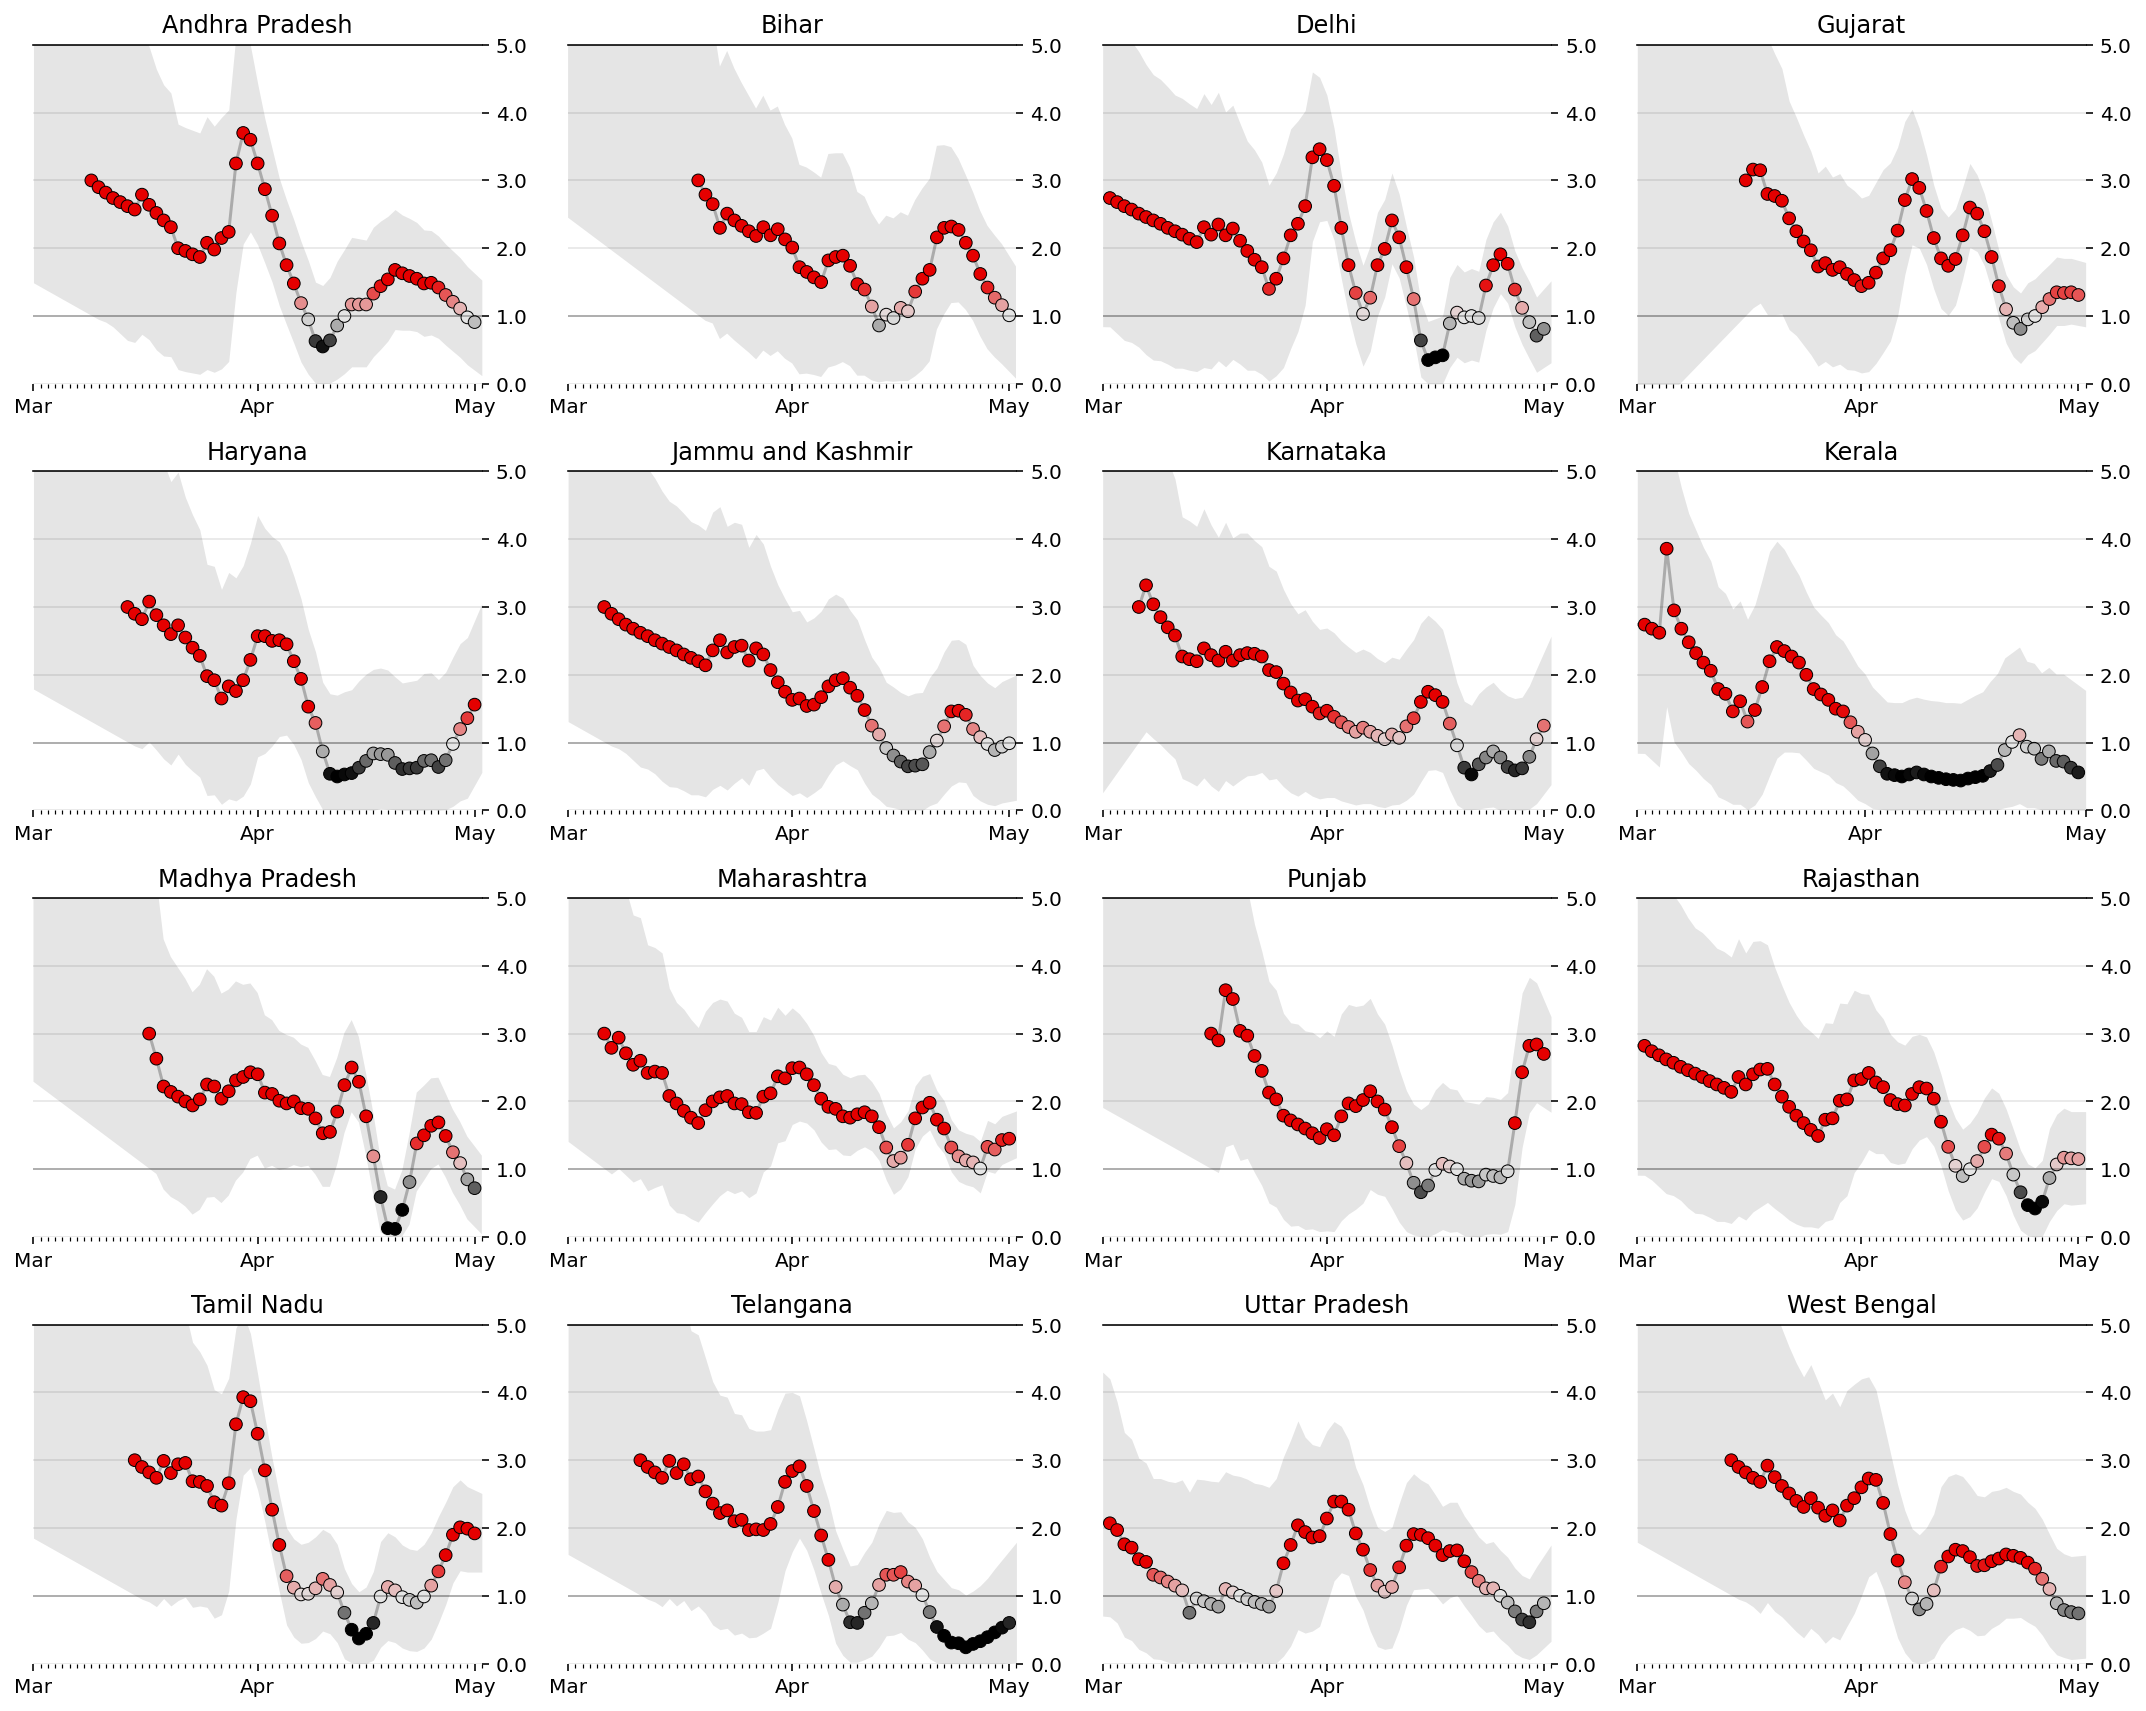

In [39]:
ncols = 4
nrows = int(np.ceil(len(results) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (state_name, result) in enumerate(final_results.groupby('state')):
    plot_rt(result, axes.flat[i], state_name)

fig.tight_layout()
fig.set_facecolor('w')

In [40]:
# Uncomment the following line if you'd like to export the data
final_results.to_csv('rt_India.csv')